In [1]:
import pandas as pd
import numpy as np
from loaders import *
import math
import random
from attn_masked import parse_timeloop_stats, aggregate_timeloop_runs
import os
import json

import matplotlib.pyplot as plt
folder = "data"

In [2]:
matrix_size = 2048 # CHANGE

dataflow_permuations = [['M', 'N', 'K'], ['M', 'K', 'N'], ['N', 'K', 'M'], ['N', 'M', 'K'], ['K', 'N', 'M'], ['K', 'M', 'N']]
'''
6 different dataflow permutations
9 components for dataflow
= 6^9 = 10077696 possible combinations
'''
# generate all the data flow permuations
def get_dataflow_permutations():
    dataflow_perumations = []
    
    for DRAM in dataflow_permuations:
        for ClusterArray in dataflow_permuations:
            for GLB_Cluster in dataflow_permuations:
                for glb in dataflow_permuations:
                    for PE_Cluster in dataflow_permuations:
                        for iact_spad in dataflow_permuations:
                            for weight_spad in dataflow_permuations:
                                for psum in dataflow_permuations:
                                    for reg in dataflow_permuations:
                                        permutation = {
                                            "DRAM": DRAM,
                                            "ClusterArray": ClusterArray,
                                            # "GLB_Cluster": GLB_Cluster,
                                            # "glb": glb,
                                            "PE_Cluster": PE_Cluster,
                                            "iact_spad": iact_spad,
                                            "weight_spad": weight_spad,
                                            "psum": psum,
                                            "reg": reg,
                                        }
                                        dataflow_perumations.append(permutation)
    return dataflow_perumations

# generate all the possible factor permutations for a specific rank (ie, M, N, or K)
def get_factor_permutations():
    factor_permutations = []
    iact_spad_depth = 16 # M, K
    weight_spad_depth = 192 # K, N
    psum_spad_depth = 32 # M, N

    max_K = int(max(math.log2(weight_spad_depth), math.log2(iact_spad_depth)))
    max_M = int(max(math.log2(psum_spad_depth), math.log2(iact_spad_depth)))
    max_N = int(max(math.log2(weight_spad_depth), math.log2(psum_spad_depth)))     
    
    for DRAM_M in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
        for DRAM_N in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:
                for DRAM_K in [2**i for i in range(int(math.log2(matrix_size)) + 1)]:

                    for iact_spad_M in [2**i for i in range(max_M + 1)]:
                        for iact_spad_K in [2**j for j in range(max_K + 1)]:
                            iact_spad_N = 1  # Inputs → M & K only
                    
                            for weight_spad_K in [2**i for i in range(max_K + 1)]:
                                for weight_spad_N in [2**j for j in range(max_N + 1)]:
                                    weight_spad_M = 1  # Weights → K & N only
                    
                                    for psum_M in [2**i for i in range(max_M + 1)]:
                                        for psum_N in [2**j for j in range(max_N + 1)]:
                                            psum_K = 1  # Outputs → M & N only
                                            # tile size must fit into the iact_spad, weight_spad, and psum_spad
                                            if not (
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_K * weight_spad_K * psum_K) <=  iact_spad_depth) and
                                                ((iact_spad_K * weight_spad_K * psum_K) * (iact_spad_N * weight_spad_N * psum_N) <=  weight_spad_depth) and
                                                ((iact_spad_M * weight_spad_M * psum_M) * (iact_spad_N * weight_spad_N * psum_N) <=  psum_spad_depth)
                                            ):
                                                break

                                            if ((DRAM_M * iact_spad_M * weight_spad_M * psum_M == matrix_size) and
                                                (DRAM_N * iact_spad_N * weight_spad_N * psum_N == matrix_size) and
                                                (DRAM_K * iact_spad_K * weight_spad_K * psum_K == matrix_size)):
                                                permuation = {
                                                    "DRAM_M": DRAM_M,
                                                    "DRAM_N": DRAM_N,
                                                    "DRAM_K": DRAM_K,

                                                    "ClusterArray_M": 1,
                                                    "ClusterArray_N": 1,
                                                    "ClusterArray_K": 1,

                                                    # "GLB_Cluster_M": 1,
                                                    # "GLB_Cluster_N": 1,
                                                    # "GLB_Cluster_K": 1,

                                                    # "glb_M": 4,
                                                    # "glb_N": 4,
                                                    # "glb_K": 4,

                                                    "PE_Cluster_M": 1,
                                                    "PE_Cluster_N": 1,
                                                    "PE_Cluster_K": 1,

                                                    "iact_spad_M": iact_spad_M,
                                                    "iact_spad_N": iact_spad_N,
                                                    "iact_spad_K": iact_spad_K,

                                                    "weight_spad_M": weight_spad_M,
                                                    "weight_spad_N": weight_spad_N,
                                                    "weight_spad_K": weight_spad_K,

                                                    "psum_M": psum_M,
                                                    "psum_N": psum_N,
                                                    "psum_K": psum_K,

                                                    "reg_M": 1,
                                                    "reg_N": 1,
                                                    "reg_K": 1,
                                                }
                                                factor_permutations.append(permuation) 
    return factor_permutations

def update_factor_permutation_helper(factor_permutation, component, max_spatial, factor):
    # factor is M, N, or K
    # component is PE_Cluster or ClusterArray
    factor_permutation[f"{component}_{factor}"] = max_spatial
    for component in ["DRAM", "iact_spad", "weight_spad", "psum", "reg"]:
        curr_component_factor = factor_permutation[f"{component}_{factor}"]
        if curr_component_factor >= max_spatial:
            factor_permutation[f"{component}_{factor}"] = curr_component_factor // max_spatial
            break
    
def update_factor_permutation(factor_permutation, dataflow_permutation):
    # Cluster Array is 8x2
    # PE_Cluster is 4x4
    possible_max_ClusterArray = [(8, 2)]
    possible_max_PE_Cluster = [(4, 4)]
    max_ClusterArray = random.choice(possible_max_ClusterArray)
    max_PE_Cluster = random.choice(possible_max_PE_Cluster)
    
    max_ClusterArray_X = max_ClusterArray[0]
    max_ClusterArray_Y = max_ClusterArray[1]
    max_PE_Cluster_X = max_PE_Cluster[0]
    max_PE_Cluster_Y = max_PE_Cluster[1]
    
    
    PE_Cluster_dataflow = dataflow_permutation["PE_Cluster"]
    PE_Cluster_dataflow_X = PE_Cluster_dataflow[0]
    PE_Cluster_dataflow_Y = PE_Cluster_dataflow[1]

    update_factor_permutation_helper(factor_permutation, "PE_Cluster", max_PE_Cluster_X, PE_Cluster_dataflow_X)
    update_factor_permutation_helper(factor_permutation, "PE_Cluster", max_PE_Cluster_Y, PE_Cluster_dataflow_Y)

    ClusterArray_dataflow = dataflow_permutation["ClusterArray"]
    ClusterArray_dataflow_X = ClusterArray_dataflow[0]
    ClusterArray_dataflow_Y = ClusterArray_dataflow[1]

    update_factor_permutation_helper(factor_permutation, "ClusterArray", max_ClusterArray_X, ClusterArray_dataflow_X)
    update_factor_permutation_helper(factor_permutation, "ClusterArray", max_ClusterArray_Y, ClusterArray_dataflow_Y)
    

In [3]:
dataflow_permutations = get_dataflow_permutations()
factor_permutations = get_factor_permutations()

In [3]:
def hash_config(config):
    return tuple((k, tuple(v) if isinstance(v, list) else v) for k, v in config.items())

def sample_config(dataflow_permutations, factor_permutations):
    factor_permutation = random.choice(factor_permutations)
    dataflow_permutation = random.choice(dataflow_permutations)

    update_factor_permutation(factor_permutation, dataflow_permutation)
    
    config = dict(
        matrix_size_M_dim=matrix_size,
        matrix_size_K_dim=matrix_size,
        matrix_size_N_dim=matrix_size,
        
        DRAM_factor_M=factor_permutation["DRAM_M"],
        DRAM_factor_N=factor_permutation["DRAM_N"],
        DRAM_factor_K=factor_permutation["DRAM_K"],
        DRAM_permutation=dataflow_permutation["DRAM"],
    
        ClusterArray_factor_M=factor_permutation["ClusterArray_M"],
        ClusterArray_factor_N=factor_permutation["ClusterArray_N"],
        ClusterArray_factor_K=factor_permutation["ClusterArray_K"],
        ClusterArray_permutation=dataflow_permutation["ClusterArray"],
    
        # GLB_Cluster_factor_M=factor_permutation["GLB_Cluster_M"],
        # GLB_Cluster_factor_N=factor_permutation["GLB_Cluster_N"],
        # GLB_Cluster_factor_K=factor_permutation["GLB_Cluster_K"],
        # GLB_Cluster_permutation=dataflow_permutation["GLB_Cluster"],
    
        # glb_factor_M=factor_permutation["glb_M"],
        # glb_factor_N=factor_permutation["glb_N"],
        # glb_factor_K=factor_permutation["glb_K"],
        # glb_permutation=dataflow_permutation["glb"],
    
        PE_Cluster_factor_M=factor_permutation["PE_Cluster_M"],
        PE_Cluster_factor_N=factor_permutation["PE_Cluster_N"],
        PE_Cluster_factor_K=factor_permutation["PE_Cluster_K"],
        PE_Cluster_permutation=dataflow_permutation["PE_Cluster"],
    
        iact_spad_factor_M=factor_permutation["iact_spad_M"],
        iact_spad_factor_N=factor_permutation["iact_spad_N"],
        iact_spad_factor_K=factor_permutation["iact_spad_K"],
        iact_spad_permutation=dataflow_permutation["iact_spad"],
    
        weight_spad_factor_M=factor_permutation["weight_spad_M"],
        weight_spad_factor_N=factor_permutation["weight_spad_N"],
        weight_spad_factor_K=factor_permutation["weight_spad_K"],
        weight_spad_permutation=dataflow_permutation["weight_spad"],
    
        psum_factor_M=factor_permutation["psum_M"],
        psum_factor_N=factor_permutation["psum_N"],
        psum_factor_K=factor_permutation["psum_K"],
        psum_permutation=dataflow_permutation["psum"],
    
        reg_factor_M=factor_permutation["reg_M"],
        reg_factor_N=factor_permutation["reg_N"],
        reg_factor_K=factor_permutation["reg_K"],
        reg_permutation=dataflow_permutation["reg"],
    
        density_weights=1,
        density_inputs=1,

        pe_meshX=4,
        pe_meshY=4,
    )
    return config

In [4]:
def evaluate_config(config, sparse_opt=None):
    if sparse_opt == None:
        sparse_opt = 'designs/baseline/baseline_sparse_opt.yaml'

    out = run_timeloop_model(
        config,
        problem='designs/baseline/baseline_problem.yaml',
        mapping='designs/baseline/baseline_mapping.yaml',
        sparse_optimizations=sparse_opt, 
    )
    stats = open('./output_dir/timeloop-model.stats.txt', 'r').read()
    return stats


def update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt, sparse_opt=None):
    q1_config, q2_config, q4_config = config.copy(), config.copy(), config.copy()
    q1_config['density_inputs'] = 0.5
    q2_config['density_inputs'] = 0.001
    q4_config['density_inputs'] = 1.0

    q1_stats = evaluate_config(q1_config, sparse_opt)
    q2_stats = evaluate_config(q2_config, sparse_opt)
    q4_stats = evaluate_config(q4_config, sparse_opt)
    
    all_stats = [q1_stats, q2_stats, q1_stats, q4_stats]
    
    parsed_runs = [parse_timeloop_stats(stats) for stats in all_stats]
    combined_stats = aggregate_timeloop_runs(parsed_runs)

    for attr in attributes: 
        if attr in ['total_energy_uJ', 'computes_per_cycle']:
            val = combined_stats[attr]
        elif attr == 'utilization_percent': 
            val = combined_stats[attr]['overall']
        elif attr == 'memory_traffic': 
            val = sum(combined_stats[attr].values())
        else: 
            raise ValueError(f"{attr} not a valid attribute.")

        if attr in ['total_energy_uJ', 'memory_traffic']: 
            if val < curr_opt[attr]:
                opt_config[attr] = config
                curr_opt[attr] = val
        elif attr in ['utilization_percent', 'computes_per_cycle']: 
            if val > curr_opt[attr]: 
                opt_config[attr] = config
                curr_opt[attr] = val


def get_initial_opt_config_and_curr_opt(attributes):
    curr_opt = {}
    for attr in attributes: 
        if attr in ['total_energy_uJ', 'memory_traffic']: 
            curr_opt[attr] = float('inf')
        elif attr in ['utilization_percent', 'computes_per_cycle']: 
            curr_opt[attr] = -float('inf')
        else: 
            raise ValueError(f"Unexpected Attribute {attr}")
            
    opt_config =  {attr: None for attr in attributes}
    return opt_config, curr_opt
    

def get_min_config_attention(attributes, num_of_random_samples = 1, default_config=None):
    print(f"optimizing over: {attributes}, num_of_random_samples: {num_of_random_samples}")
    visited = set()
                
    opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
    
    # uses random sampling instead of a for loop
    for sample in range(num_of_random_samples):
        # print("\nsample: ", sample, "curr_min", curr_min)
        
        config = sample_config(dataflow_permutations, factor_permutations)
        while hash_config(config) in visited:
            config = sample_config(dataflow_permutations, factor_permutations)
        visited.add(hash_config(config))
        # print("config: ", config)

        try: 
            update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt)
        except: 
            continue

    return opt_config, curr_opt

In [ ]:
num_of_random_samples = 250
attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
min_config, curr_min = get_min_config_attention(attributes, num_of_random_samples)
print("==================OUTPUT==================")
# print("min_config: ", min_config)
print("curr_min: ", curr_min)

optimizing over: ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic'], num_of_random_samples: 250
[INFO] 2025-05-04 22:28:33,773 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:28:44,576 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:28:55,307 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:29:06,391 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:29:17,246 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:29:28,208 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:29:39,154 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:29:50,009 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:01,072 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:11,700 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:23,013 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:33,995 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:44,922 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:30:55,420 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:31:06,057 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:31:16,437 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:31:27,056 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:31:37,588 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:31:49,795 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:00,442 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:11,108 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:21,740 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:32,355 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:42,994 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:32:54,093 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:33:05,297 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:33:15,980 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:33:27,010 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:33:37,880 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:33:48,690 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:00,054 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:10,921 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:21,494 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:32,479 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:43,309 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:34:54,061 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:04,935 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:15,527 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:26,148 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:36,877 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:47,355 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:35:57,891 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:36:08,584 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:36:19,504 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:36:33,063 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:36:43,776 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:36:54,877 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:05,672 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:16,223 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:27,135 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:38,036 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:48,662 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:37:59,510 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:38:10,214 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:38:20,821 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:38:31,766 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:38:42,328 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:38:53,173 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:04,202 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:14,873 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:25,694 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:36,627 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:47,180 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:39:57,883 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:40:08,744 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:40:19,415 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:40:30,358 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:40:40,927 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:40:53,520 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:04,320 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:14,956 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:25,946 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:36,589 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:47,274 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:41:57,951 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:08,779 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:19,445 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:30,176 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:40,886 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:42:51,776 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:02,710 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:13,328 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:24,217 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:35,017 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:45,675 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:43:56,383 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:44:07,013 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:44:17,900 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:44:28,787 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:44:39,475 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:44:50,076 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:00,878 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:11,364 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:22,096 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:34,987 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:45,821 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:45:56,667 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:46:07,523 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:46:18,284 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:46:29,603 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:46:40,222 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:46:51,257 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:02,287 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:12,823 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:23,671 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:34,494 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:45,235 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:47:55,975 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:06,490 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:17,309 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:28,192 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:38,611 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:49,223 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:48:59,682 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:49:10,226 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:49:21,156 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:49:32,011 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:49:42,667 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:49:55,427 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:50:07,391 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:50:18,309 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:50:28,593 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:50:40,113 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:50:51,006 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:02,031 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:12,697 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:23,526 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:34,080 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:44,706 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:51:55,542 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:52:06,373 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:52:17,632 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:52:30,646 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:52:41,591 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:52:52,281 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:02,997 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:13,722 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:24,654 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:35,536 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:46,276 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:53:57,329 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:54:08,213 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:54:19,196 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:54:30,193 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:54:43,029 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:54:53,854 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:04,717 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:15,595 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:26,485 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:37,030 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:47,772 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:55:58,442 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:56:09,094 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:56:19,829 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:56:30,816 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:56:41,712 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:56:52,474 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:03,286 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:14,043 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:25,081 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:35,883 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:46,581 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:57:57,345 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:58:07,956 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:58:18,756 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:58:29,479 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:58:40,530 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:58:51,311 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:03,953 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:14,644 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:25,531 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:36,344 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:47,381 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 22:59:58,321 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:00:08,919 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:00:19,861 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:00:30,946 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:00:41,950 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:00:53,178 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:04,279 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:15,535 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:26,566 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:37,594 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:48,655 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:01:59,982 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:02:11,002 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:02:22,237 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:02:33,504 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:02:44,676 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:02:56,119 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:03:06,896 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:03:18,170 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:03:29,302 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:03:39,983 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:03:52,812 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:03,716 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:14,391 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:25,323 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:35,996 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:46,672 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:04:57,541 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:05:08,173 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:05:18,930 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:05:29,784 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:05:40,443 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:05:51,513 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:02,339 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:13,133 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:24,230 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:35,073 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:45,762 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:06:56,591 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:07:07,090 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:07:17,924 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:07:28,691 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:07:39,312 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:07:50,194 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:01,081 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:13,851 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:25,057 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:36,072 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:47,101 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:08:57,993 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:09:08,727 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:09:20,001 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:09:30,738 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:09:41,538 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:09:52,417 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:03,240 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:14,341 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:25,636 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:36,460 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:47,318 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:10:58,094 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:11:08,823 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:11:19,711 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:11:30,649 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:11:41,513 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:11:52,596 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:03,505 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:14,399 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:25,281 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:36,097 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:49,153 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:12:59,818 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:13:10,533 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:13:21,339 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:13:32,190 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:13:42,932 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:13:53,671 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:04,137 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:14,991 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:26,007 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:36,625 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:47,668 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:14:58,432 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:15:09,255 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:15:20,219 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:15:31,062 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:15:41,781 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:15:52,726 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:03,510 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:14,159 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:24,902 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:35,445 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:46,267 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:16:57,169 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:17:07,653 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:17:20,549 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:17:31,320 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:17:42,266 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:17:53,190 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:03,763 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:14,375 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:25,462 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:36,059 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:47,011 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:18:57,779 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:19:08,363 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:19:19,327 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:19:29,973 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:19:40,711 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:19:51,657 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:02,519 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:13,415 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:24,248 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:34,602 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:45,524 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:20:56,130 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:21:06,931 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:21:17,859 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:21:28,366 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:21:40,868 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:21:51,977 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:02,775 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:13,538 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:24,458 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:34,926 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:45,645 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:22:56,428 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:23:07,182 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:23:17,858 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:23:28,746 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:23:39,641 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:23:50,466 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:01,207 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:12,039 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:22,819 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:33,443 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:44,193 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:24:55,116 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:25:05,933 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:25:16,747 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:25:27,690 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:25:38,224 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:25:49,183 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:00,053 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:10,922 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:24,312 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:34,925 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:45,982 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:26:56,812 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:27:07,713 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:27:18,690 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:27:29,502 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:27:40,122 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:27:50,846 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:01,728 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:12,652 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:23,572 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:34,261 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:45,098 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:28:55,954 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:29:06,716 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:29:17,413 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:29:28,239 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:29:39,048 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:29:50,037 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:00,582 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:11,389 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:22,422 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:33,080 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:45,978 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:30:56,528 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:31:07,310 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:31:18,266 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:31:28,941 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:31:39,666 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:31:50,871 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:01,533 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:12,458 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:23,376 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:33,859 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:44,548 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:32:55,242 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:06,222 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:16,935 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:27,738 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:40,348 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:33:55,038 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:08,969 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:24,100 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:37,114 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:48,190 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:34:58,845 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:09,549 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:20,428 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:30,984 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:35:46,653 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:53:36,069 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:53:54,467 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:54:12,692 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:54:32,641 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:54:52,063 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:55:11,767 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:55:32,281 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:55:52,008 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:56:10,763 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:56:30,348 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:56:50,142 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:57:09,015 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:57:28,646 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:57:47,640 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:58:07,352 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:58:27,042 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:58:45,282 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:59:04,618 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:59:23,573 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-04 23:59:42,979 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:00:01,182 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:00:19,687 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:00:38,362 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:00:59,890 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:01:19,250 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:01:39,055 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:01:58,677 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:02:18,027 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:02:37,513 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:02:57,527 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:03:16,478 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:03:35,441 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:03:54,866 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:04:14,990 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:04:33,501 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:04:52,835 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:05:11,377 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:05:30,466 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:05:49,704 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:06:08,337 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:06:28,851 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:06:48,304 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:07:06,425 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:07:26,148 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:07:44,447 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:08:03,178 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:08:21,514 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:08:39,476 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:08:57,833 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:09:20,836 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:09:39,057 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:09:57,733 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:10:16,416 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:10:35,137 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:10:53,478 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:11:13,991 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:11:33,027 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:11:52,603 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:12:11,561 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:12:30,833 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:12:51,368 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:13:09,547 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:13:29,431 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:13:49,983 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:14:10,002 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:14:28,822 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:14:47,952 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:15:07,054 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:15:26,401 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:15:45,817 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:16:04,958 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:16:24,564 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:16:44,413 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:17:05,072 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:17:22,817 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:17:41,688 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:17:59,694 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:18:17,763 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:18:36,548 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:18:55,910 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:19:15,628 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:19:34,446 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:19:52,784 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:20:12,135 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:20:31,443 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:20:49,813 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:21:07,566 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:21:27,151 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:21:46,473 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:22:04,548 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:22:23,522 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:22:42,426 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:23:01,711 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:23:20,246 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:23:40,041 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:23:58,075 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:24:15,336 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:24:34,586 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:24:52,900 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:25:15,080 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:25:35,899 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:25:57,625 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:26:03,536 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 00:26:20,065 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


In [96]:
# !timeloop model ./output_dir/parsed-processed-input.yaml

Running apps: model
Found parsed-processed-input.yaml in input files. Running Timeloop without parsing or processing steps. If this is not the intended behavior, please name the input files differently.
input file: /home/workspace/final_project/output_dir/parsed-processed-input.yaml
execute:/usr/local/bin/accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Start Parsering Layout
No Layout specified, so using bandwidth based modeling
ERROR: couldn't map level DRAM: more compression ranks needed than supported in hardware. dataspace name: Inputs


In [ ]:
# name = "bello" #Change
# os.makedirs(f"{folder}", exist_ok=True)

# with open(f"{folder}/250_min_config_{name}", "w") as f:
#     json.dump(min_config, f, indent=2)
# with open(f"{folder}/250_curr_min_{name}", "w") as f:
#     json.dump(curr_min, f, indent=2)

In [8]:
# Change the number of PE's and keep the config the same
default_config = {
    "matrix_size_M_dim": 2048,
    "matrix_size_K_dim": 2048,
    "matrix_size_N_dim": 2048,
    "DRAM_factor_M": 128,
    "DRAM_factor_N": 16,
    "DRAM_factor_K": 64,
    "DRAM_permutation": [
      "K",
      "M",
      "N"
    ],
    "ClusterArray_factor_M": 2,
    "ClusterArray_factor_N": 8,
    "ClusterArray_factor_K": 1,
    "ClusterArray_permutation": [
      "N",
      "M",
      "K"
    ],
    "PE_Cluster_factor_M": 4,
    "PE_Cluster_factor_N": 1,
    "PE_Cluster_factor_K": 4,
    "PE_Cluster_permutation": [
      "K",
      "M",
      "N"
    ],
    "iact_spad_factor_M": 1,
    "iact_spad_factor_N": 1,
    "iact_spad_factor_K": 2,
    "iact_spad_permutation": [
      "K",
      "M",
      "N"
    ],
    "weight_spad_factor_M": 1,
    "weight_spad_factor_N": 1,
    "weight_spad_factor_K": 4,
    "weight_spad_permutation": [
      "K",
      "N",
      "M"
    ],
    "psum_factor_M": 2,
    "psum_factor_N": 16,
    "psum_factor_K": 1,
    "psum_permutation": [
      "K",
      "N",
      "M"
    ],
    "reg_factor_M": 1,
    "reg_factor_N": 1,
    "reg_factor_K": 1,
    "reg_permutation": [
      "N",
      "K",
      "M"
    ],
    "density_weights": 1,
    "density_inputs": 1,
    "pe_meshX": 4,
    "pe_meshY": 4,
}

In [13]:
def update_pe_cluster_helper(config, component, factor, max_spatial, curr_spatial):
        # factor is M, N, or K
        # component is PE_Cluster or ClusterArray
        config[f"{component}_factor_{factor}"] = max_spatial
        for component in ["DRAM", "iact_spad", "weight_spad", "psum", "reg"]:
            curr_component_factor = config[f"{component}_factor_{factor}"]
            # looking to increase the other components
            if curr_spatial > max_spatial:
                # print("entering here")
                config[f"{component}_factor_{factor}"] = curr_component_factor * (curr_spatial // max_spatial)
                break
            # looking to decrease the other components
            if curr_spatial < max_spatial:
                # print("bob here")
                if curr_component_factor >= max_spatial:
                    config[f"{component}_factor_{factor}"] = curr_component_factor // (max_spatial // curr_spatial)
                    break

def update_pe_cluster(config, pe_X, pe_Y):
    curr_pe_meshX = config['pe_meshX']
    curr_pe_meshY = config['pe_meshY']
    # print("curr_pe_meshX: ", curr_pe_meshX)
    # print("curr_pe_meshY: ", curr_pe_meshY)
    
    config['pe_meshX'] = pe_X
    config['pe_meshY'] = pe_Y

    PE_Cluster_dataflow = config["PE_Cluster_permutation"]
    PE_Cluster_factor_X = PE_Cluster_dataflow[0]
    PE_Cluster_factor_Y = PE_Cluster_dataflow[1]

    # print("before: ", config)
    update_pe_cluster_helper(config, "PE_Cluster", PE_Cluster_factor_X, pe_X, curr_pe_meshX)
    update_pe_cluster_helper(config, "PE_Cluster", PE_Cluster_factor_Y, pe_Y, curr_pe_meshY)
    # print("after: ", config)

# Change the number of PE's and keep the config the same
def get_pe_experiment_data(config, attributes, min_pe_power=2, max_pe_power=2):
    min_pe = 1
    pe_data = {}
    pe_range = [2**i for i in range(min_pe_power, max_pe_power + 1)]
    for pe_X in pe_range:
        for pe_Y in pe_range:
            update_pe_cluster(config, pe_X, pe_Y)
    
            opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
            update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt)
            pe_data[(pe_X, pe_Y)] = curr_opt
    return pe_data

attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
min_pe_power=0
max_pe_power=4
pe_data = get_pe_experiment_data(default_config, attributes, min_pe_power, max_pe_power)

serializable_data = {f"{k[0]},{k[1]}": v for k, v in pe_data.items()}

with open(f"{folder}/pe_experiment_data.json", "w") as f:
    json.dump(serializable_data, f, indent=4)

[INFO] 2025-05-05 01:42:25,085 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:42:46,506 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:43:06,788 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:43:26,237 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:43:46,297 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:44:07,087 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:44:26,185 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:44:46,021 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:45:06,667 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:45:25,946 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:45:46,436 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:46:05,957 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:46:26,149 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:46:46,363 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:03,255 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:14,223 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:25,123 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:36,757 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:47,795 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:47:58,673 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:48:09,506 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:48:20,339 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:48:31,162 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:48:42,295 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:48:53,078 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:04,058 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:15,513 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:26,411 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:37,234 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:48,444 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:49:58,923 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:50:09,868 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:50:21,002 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:50:32,211 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:50:43,369 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:50:54,231 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:51:05,377 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:51:16,764 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:51:27,422 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:51:38,717 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:51:49,106 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:00,255 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:11,484 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:22,218 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:33,161 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:44,164 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:52:55,085 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:53:05,998 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:53:17,044 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:53:27,963 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:53:39,211 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:53:51,011 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:54:04,207 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:54:17,477 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:54:31,786 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:54:45,865 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:54:58,887 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:55:12,756 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:55:25,600 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:55:39,128 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:55:52,117 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:56:06,518 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:56:20,004 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:56:31,311 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:56:42,360 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:56:53,143 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:04,069 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:15,286 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:25,610 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:36,786 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:47,609 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:57:58,427 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:58:09,287 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:58:19,761 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 01:58:30,473 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


In [131]:
# !timeloop model ./output_dir/parsed-processed-input.yaml

Running apps: model
Found parsed-processed-input.yaml in input files. Running Timeloop without parsing or processing steps. If this is not the intended behavior, please name the input files differently.
input file: /home/workspace/final_project/output_dir/parsed-processed-input.yaml
execute:/usr/local/bin/accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
ERROR: parsing mapping: product of all factors of dimension M is 512, which is not equal to the dimension size of the workload 2048.
ERROR: parsing mapping: product of all factors of dimension N is 512, which is not equal to the dimension size of the workload 2048.


pe_data:  {(1, 1): {'total_energy_uJ': 859121.4500000001, 'utilization_percent': 100.0, 'computes_per_cycle': 15.999999999069143, 'memory_traffic': 150618597490}, (1, 2): {'total_energy_uJ': 584243.57, 'utilization_percent': 100.0, 'computes_per_cycle': 31.999999968350856, 'memory_traffic': 146323630194}, (1, 4): {'total_energy_uJ': 446804.61, 'utilization_percent': 100.0, 'computes_per_cycle': 63.99999993670171, 'memory_traffic': 144176146546}, (1, 8): {'total_energy_uJ': 378085.13, 'utilization_percent': 100.0, 'computes_per_cycle': 127.99999987340342, 'memory_traffic': 143102404722}, (1, 16): {'total_energy_uJ': 343725.39, 'utilization_percent': 100.0, 'computes_per_cycle': 255.99999784041145, 'memory_traffic': 142565533810}, (2, 1): {'total_energy_uJ': 859119.52, 'utilization_percent': 100.0, 'computes_per_cycle': 31.999999968350856, 'memory_traffic': 150601820274}, (2, 2): {'total_energy_uJ': 584241.6000000001, 'utilization_percent': 100.0, 'computes_per_cycle': 63.99999993670171,

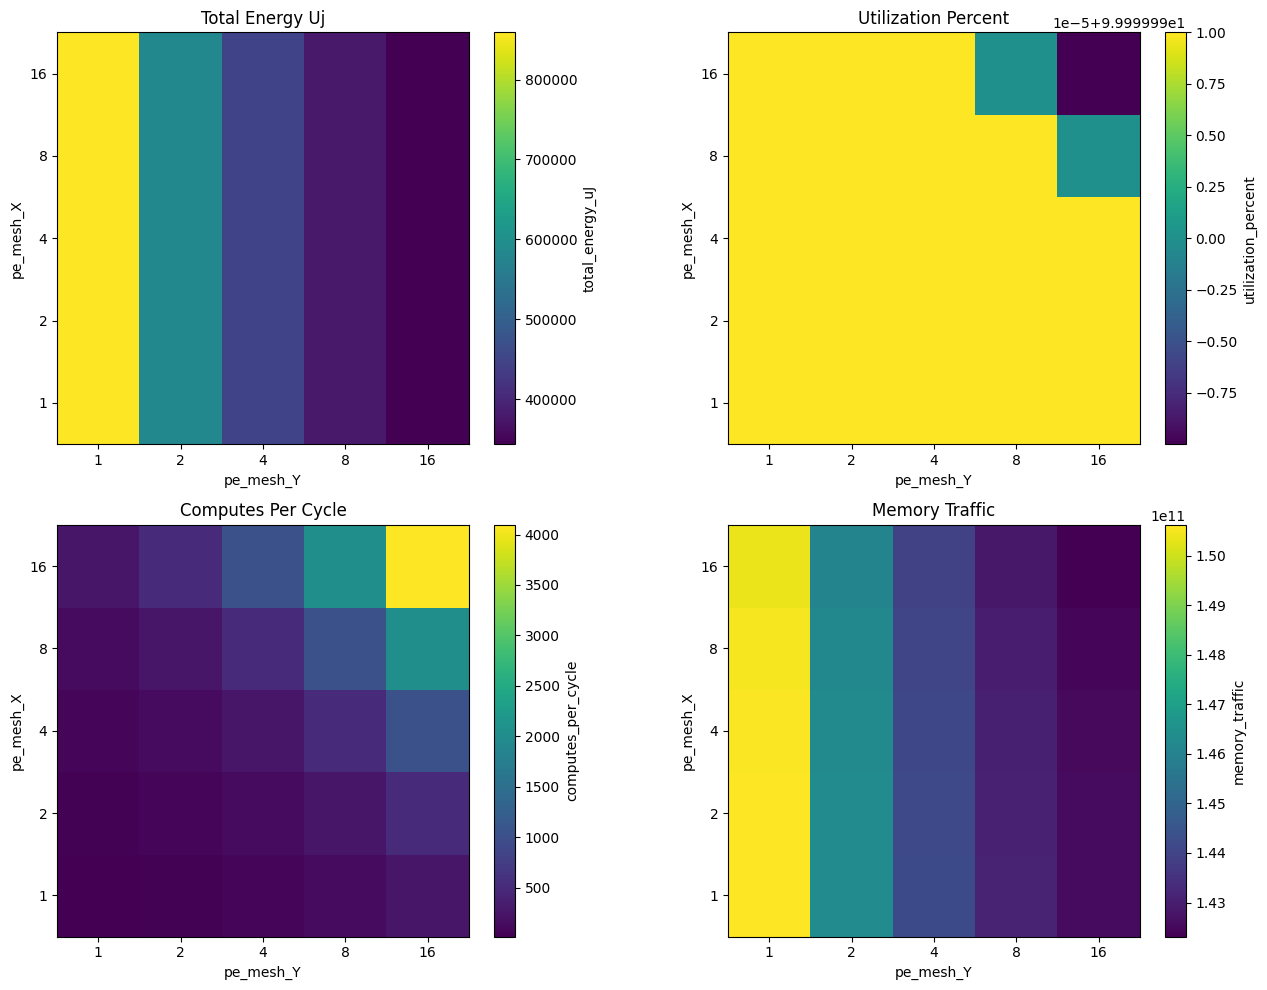

In [14]:
with open(f"{folder}/pe_experiment_data.json", "r") as f:
    loaded_data = json.load(f)
pe_data = {tuple(map(int, k.split(','))): v for k, v in loaded_data.items()}
print("pe_data: ", pe_data)
pe_range = [2**i for i in range(min_pe_power, max_pe_power + 1)]

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, attr in enumerate(attributes):
    heatmap = np.zeros((len(pe_range), len(pe_range)))

    for row_idx, pe_X in enumerate(pe_range):
        for col_idx, pe_Y in enumerate(pe_range):
            value = pe_data.get((pe_X, pe_Y), {}).get(attr, 0)  # Default to 0 if missing
            heatmap[row_idx, col_idx] = value

    im = axs[i].imshow(heatmap, origin='lower', cmap='viridis')
    axs[i].set_title(attr.replace('_', ' ').title())
    axs[i].set_xlabel('pe_mesh_Y')
    axs[i].set_ylabel('pe_mesh_X')
    axs[i].set_xticks(np.arange(len(pe_range)))
    axs[i].set_yticks(np.arange(len(pe_range)))
    axs[i].set_xticklabels(pe_range)
    axs[i].set_yticklabels(pe_range)

    cbar = plt.colorbar(im, ax=axs[i], fraction=0.046, pad=0.04)
    cbar.set_label(attr)

plt.tight_layout()
plt.show()

In [28]:
# change the sparsity
def get_CSR_vs_COO(config, attributes):
    sparse_opt_dict = {}
    for sparse_repr  in ["CSR", "COO"]:
        sparse_opt = f"designs/attention/{sparse_repr}.yaml"
        opt_config, curr_opt =  get_initial_opt_config_and_curr_opt(attributes)
        update_opt_config_and_curr_opt(config, attributes, opt_config, curr_opt, sparse_opt)
        sparse_opt_dict[sparse_repr] = curr_opt
    return sparse_opt_dict

attributes = ['total_energy_uJ', 'utilization_percent', 'computes_per_cycle', 'memory_traffic']
sparse_opt_dict = get_CSR_vs_COO(default_config, attributes)
# print("sparse_opt_dict: ", sparse_opt_dict)

with open(f"{folder}/sparse_opt_data.json", "w") as f:
    json.dump(sparse_opt_dict, f, indent=4)

[INFO] 2025-05-05 03:08:58,245 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 03:09:08,351 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 03:09:19,640 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 03:09:30,866 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 03:09:40,943 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


[INFO] 2025-05-05 03:09:51,828 - pytimeloop.accelergy_interface - Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


INFO:pytimeloop.accelergy_interface:Running Accelergy with command: accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml -o ./output_dir/ -v


In [16]:
# !timeloop model ./output_dir/parsed-processed-input.yaml

Running apps: model
Found parsed-processed-input.yaml in input files. Running Timeloop without parsing or processing steps. If this is not the intended behavior, please name the input files differently.
input file: /home/workspace/final_project/output_dir/parsed-processed-input.yaml
execute:/usr/local/bin/accelergy /home/workspace/final_project/output_dir/parsed-processed-input.yaml --oprefix timeloop-model. -o ./ > timeloop-model.accelergy.log 2>&1
Start Parsering Layout
No Layout specified, so using bandwidth based modeling
ERROR: couldn't map level DRAM: more compression ranks needed than supported in hardware. dataspace name: Inputs


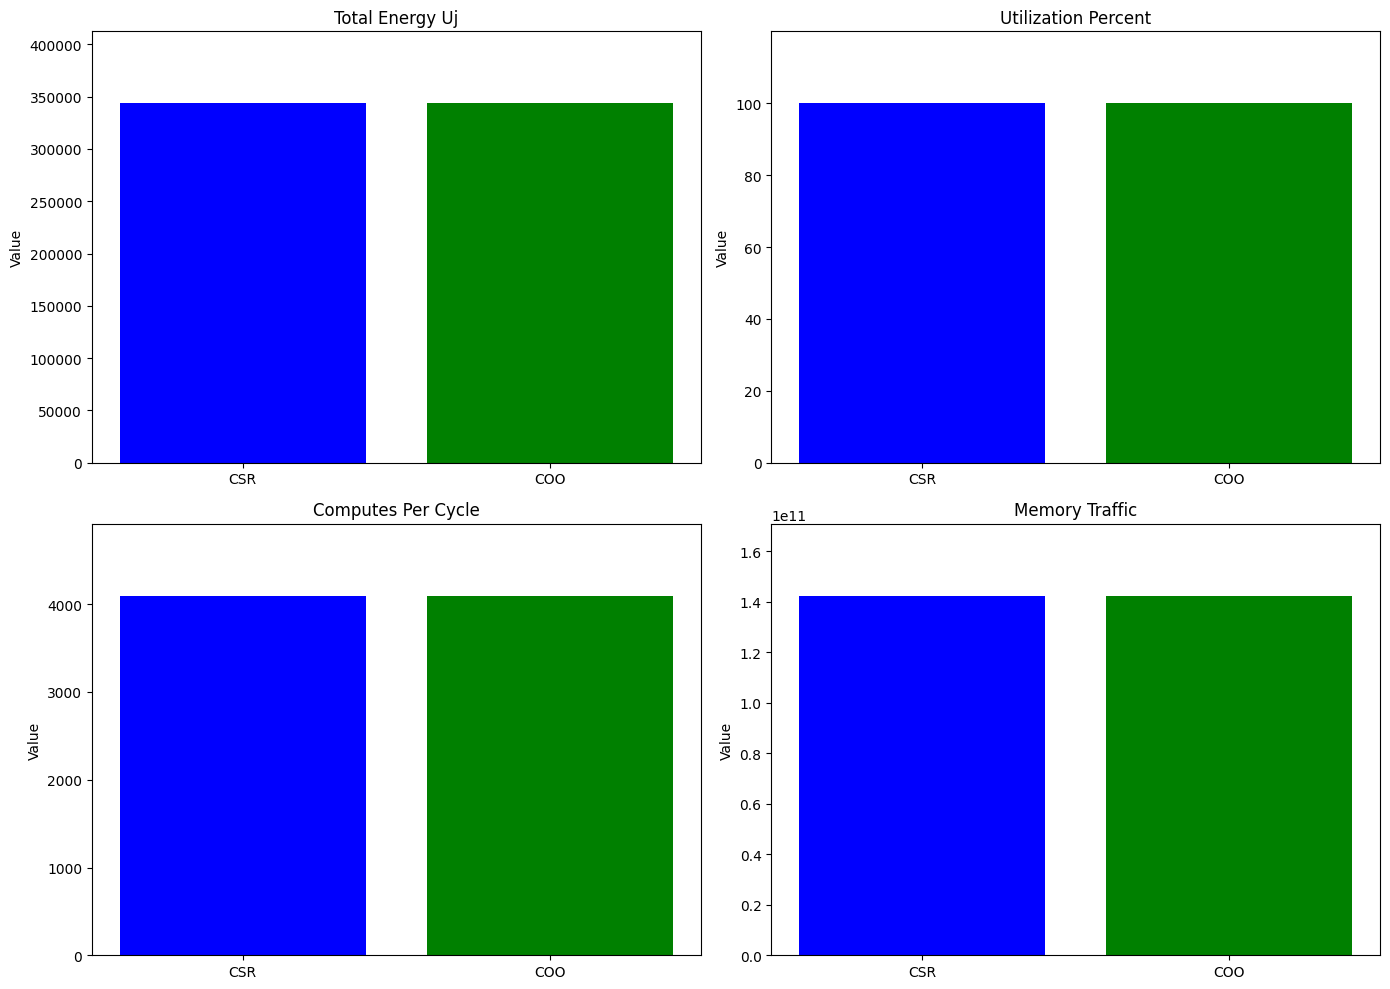

In [29]:
with open(f"{folder}/sparse_opt_data.json", "r") as f:
    loaded_data = json.load(f)
sparse_opt_data = loaded_data

sparsity_opt_data = {
    'CSR': {
        'total_energy_uJ': 1,
        'utilization_percent': 1,
        'computes_per_cycle': 1,
        'memory_traffic': 1
    },
    'COO': {
        'total_energy_uJ': 1,
        'utilization_percent': 1,
        'computes_per_cycle': 1,
        'memory_traffic': 1
    },
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, attr in enumerate(attributes):
    csr_val = sparse_opt_data["CSR"].get(attr, 0)
    coo_val = sparse_opt_data["COO"].get(attr, 0)

    axs[i].bar(["CSR", "COO"], [csr_val, coo_val], color=["blue", "green"])
    axs[i].set_title(attr.replace('_', ' ').title())
    axs[i].set_ylabel("Value")
    axs[i].set_ylim(0, max(csr_val, coo_val) * 1.2)  # add headroom

plt.tight_layout()
plt.show()